# Analyzing Bike Sharing Trends

# Problem Statement

- To encourage bike usage, cities across the world have successfully rolled out bike sharing programs. Under such schemes, riders can rent bicycles using manual/ automated kiosks spread across the city for defined periods. In most cases, riders can pick up bikes from one location and return them to any other designated place. 
- The bike sharing platforms from across the world are hotspots of all sorts of data, ranging from travel time, start and end location, demographics of riders, and so on. This data along with alternate sources of information such as weather, traffic, terrain, and so on makes it an attractive proposition for different research areas. 
- The Capital Bike Sharing dataset contains information related to one such bike sharing program underway in Washington DC. Given this augmented (bike sharing details along with weather information) dataset, **can we forecast bike rental demand for this program?**

# 1. Importing Libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Basic Libraries ##
import numpy as np
import pandas as pd


## Plotting Libraries ##
import matplotlib.pyplot as plt
import seaborn as sns

## sklearn libraries ##


## Other Libraries ##
from tqdm import tqdm
from collections import Counter
import calendar
from datetime import datetime
from scipy import stats

# 2. Training Data Analysis

# 2.1 Data Loading 

In [2]:
hourly_data = pd.read_csv('train.csv')

In [3]:
print('Shape of the Hour Dataset :{}'.format(hourly_data.shape))

Shape of the Hour Dataset :(10886, 12)


In [4]:
hourly_data.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


## Data Description

Data Fields

1. datetime - hourly date + timestamp  
2. season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
3. holiday - whether the day is considered a holiday
4. workingday - whether the day is neither a weekend nor holiday
5. weather - 
        - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
        - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
        - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
        - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
6. temp - temperature in Celsius
7. atemp - "feels like" temperature in Celsius
8. humidity - relative humidity
9. windspeed - wind speed
10. casual - number of non-registered user rentals initiated
11. registered - number of registered user rentals initiated
12. count - number of total rentals

# 2.2 Data Cleaning 

In [5]:
# Clean up the attribute names to make them more understandable.

hourly_data.rename(columns = {'holiday':'is_holiday','workingday':'is_workingday','count':'total_count'}, inplace = True)

## Feature Engineering

In [6]:
# Creating New Columns From "datetime" Column

hourly_data["date"] = hourly_data.datetime.apply(lambda x : x.split()[0])
hourly_data["hour"] = hourly_data.datetime.apply(lambda x : x.split()[1].split(":")[0])

hourly_data["season"] = hourly_data.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
hourly_data["weather"] = hourly_data.weather.map({1: "Clear, Few clouds, Partly cloudy",\
                                        2 : "Cloudy, Broken clouds, Few clouds, Mist", \
                                        3 : "Light Snow, Light Rain, Thunderstorm, Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :"Heavy Rain, Ice Pallets, Thunderstorm, Mist, Snow, Fog" })

hourly_data["weekday"] = hourly_data.date.apply(lambda x : calendar.day_name[datetime.strptime(x,"%Y-%m-%d").weekday()])
hourly_data["month"] = hourly_data.date.apply(lambda x : calendar.month_name[datetime.strptime(x,"%Y-%m-%d").month])
hourly_data["year"] = hourly_data.datetime.apply(lambda x : x.split()[0].split('-')[0])

In [7]:
hourly_data.head()

,datetime,season,is_holiday,is_workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_count,date,hour,weekday,month,year
0,2011-01-01 00:00:00,Spring,0,0,"Clear, Few clouds, Partly cloudy",9.84,14.395,81,0.0,3,13,16,2011-01-01,00,Saturday,January,2011
1,2011-01-01 01:00:00,Spring,0,0,"Clear, Few clouds, Partly cloudy",9.02,13.635,80,0.0,8,32,40,2011-01-01,01,Saturday,January,2011
2,2011-01-01 02:00:00,Spring,0,0,"Clear, Few clouds, Partly cloudy",9.02,13.635,80,0.0,5,27,32,2011-01-01,02,Saturday,January,2011
3,2011-01-01 03:00:00,Spring,0,0,"Clear, Few clouds, Partly cloudy",9.84,14.395,75,0.0,3,10,13,2011-01-01,03,Saturday,January,2011
4,2011-01-01 04:00:00,Spring,0,0,"Clear, Few clouds, Partly cloudy",9.84,14.395,75,0.0,0,1,1,2011-01-01,04,Saturday,January,2011


In [8]:
# check what data types pandas has inferred and if any of the attributes require type conversions

hourly_data.dtypes

datetime          object
season            object
is_holiday         int64
is_workingday      int64
weather           object
temp             float64
atemp            float64
humidity           int64
windspeed        float64
casual             int64
registered         int64
total_count        int64
date              object
hour              object
weekday           object
month             object
year              object
dtype: object

In [9]:
# Attributes like "hour", "weekday" ,"month" ,"season" ,"weather"  are inferred as objects but require the conversion to categoricals.
# Also Attributes like "is_holiday", "is_workingday" are inferred as integers but require the conversion to categoricals.

# categorical variables
category_var_list = ["hour", "weekday" ,"month" ,"season" ,"weather","is_holiday", "is_workingday"]

for var in category_var_list:
    
    hourly_data[var] = hourly_data[var].astype('category')

In [10]:
hourly_data.dtypes

datetime           object
season           category
is_holiday       category
is_workingday    category
weather          category
temp              float64
atemp             float64
humidity            int64
windspeed         float64
casual              int64
registered          int64
total_count         int64
date               object
hour             category
weekday          category
month            category
year               object
dtype: object

In [11]:
# Dropping Unncessary Columns

#hourly_data.drop(['datetime'], axis = 1, inplace = True)

In [12]:
hourly_data.head()

,datetime,season,is_holiday,is_workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_count,date,hour,weekday,month,year
0,2011-01-01 00:00:00,Spring,0,0,"Clear, Few clouds, Partly cloudy",9.84,14.395,81,0.0,3,13,16,2011-01-01,00,Saturday,January,2011
1,2011-01-01 01:00:00,Spring,0,0,"Clear, Few clouds, Partly cloudy",9.02,13.635,80,0.0,8,32,40,2011-01-01,01,Saturday,January,2011
2,2011-01-01 02:00:00,Spring,0,0,"Clear, Few clouds, Partly cloudy",9.02,13.635,80,0.0,5,27,32,2011-01-01,02,Saturday,January,2011
3,2011-01-01 03:00:00,Spring,0,0,"Clear, Few clouds, Partly cloudy",9.84,14.395,75,0.0,3,10,13,2011-01-01,03,Saturday,January,2011
4,2011-01-01 04:00:00,Spring,0,0,"Clear, Few clouds, Partly cloudy",9.84,14.395,75,0.0,0,1,1,2011-01-01,04,Saturday,January,2011


# 2.3 EDA Before Having Look on Outliers

In [13]:
# Visualization Of Variables DataType Count

data_type_df = pd.DataFrame(data = hourly_data.dtypes.value_counts()).reset_index().rename(columns={"index":'variableType', 0:'count'})
data_type_df.columns

Index(['variableType', 'count'], dtype='object')

In [14]:
data_type_df.head(10)

,variableType,count
0,int64,4
1,object,3
2,float64,3
3,category,2
4,category,1
5,category,1
6,category,1
7,category,1
8,category,1


In [15]:
# Missing Values Analysis

print('Number of missing values :\n{}'.format(hourly_data.isnull().sum()))

Number of missing values :
datetime         0
season           0
is_holiday       0
is_workingday    0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
casual           0
registered       0
total_count      0
date             0
hour             0
weekday          0
month            0
year             0
dtype: int64


## Data Visualization : Distribution and Trends

[Text(0.5, 1.0, 'Season wise Hourly distribution of Total Counts \n')]

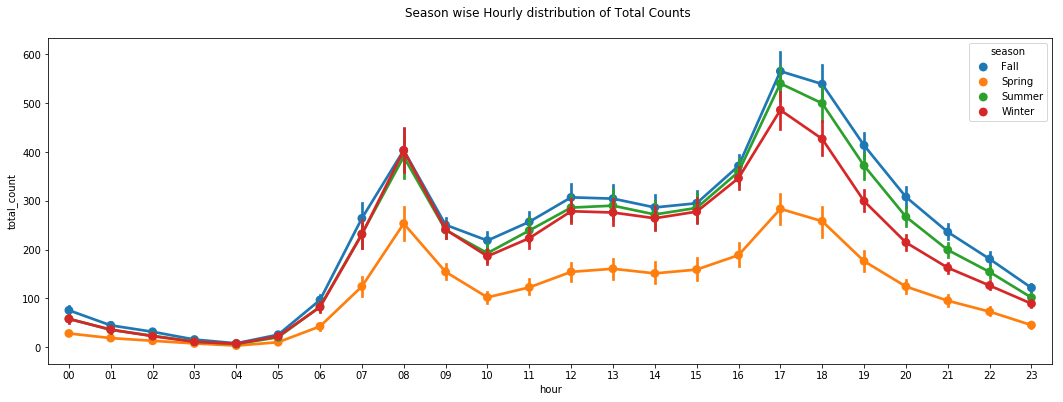

In [16]:
# Visualizing hourly ridership counts across the seasons.

fig, ax = plt.subplots(figsize = (18,6))
sns.pointplot(data = hourly_data[['hour', 'season', 'total_count']], 
              x = 'hour', y = 'total_count', hue = 'season', ax = ax)
ax.set(title = "Season wise Hourly distribution of Total Counts \n")

**Observations**

1. Similar trends have been seen in all the seasons with counts peaking in the morning between 7-9 am and in the evening between 4-6 pm, possibly due to high movement during start and end of office hours. 
2. The counts are lowest for the spring season, while fall sees highest riders across all 24 hours.

[Text(0.5, 1.0, 'Day wise Hourly distribution of Total Counts \n')]

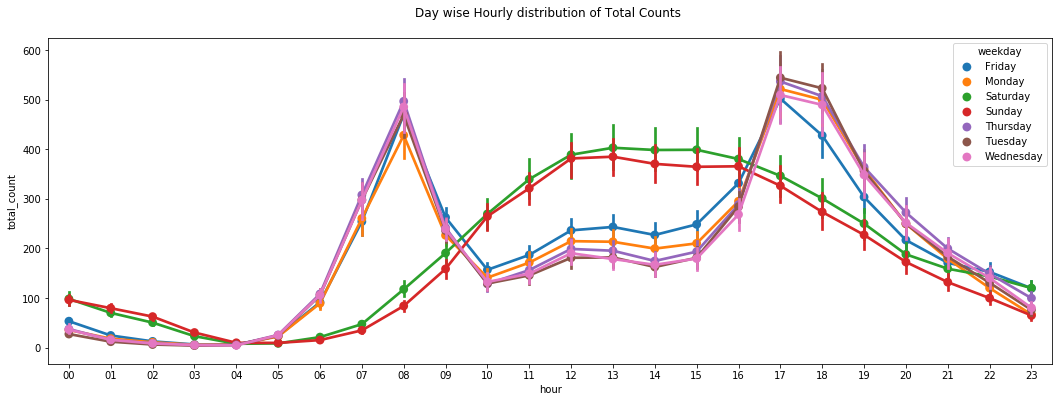

In [17]:
# Visualizing hourly ridership counts across the weekdays.

fig, ax = plt.subplots(figsize = (18,6))
sns.pointplot(data = hourly_data[['hour', 'weekday', 'total_count']], 
              x = 'hour', y = 'total_count', hue = 'weekday', ax = ax)
ax.set(title = "Day wise Hourly distribution of Total Counts \n")

**Observations**

1. Similar trends have been seen during **Moday -Friday** with counts peaking in the morning between 7-9 am and in the evening between 4-6 pm, possibly due to high movement during start and end of office hours. 
2. Similar trends have been seen during **Saturday-Sunday** with counts peaking in afternoon hours between 11 am - 4 pm, possibly due to weekends.

[Text(0.5, 1.0, 'Monthly distribution of Total Counts \n')]

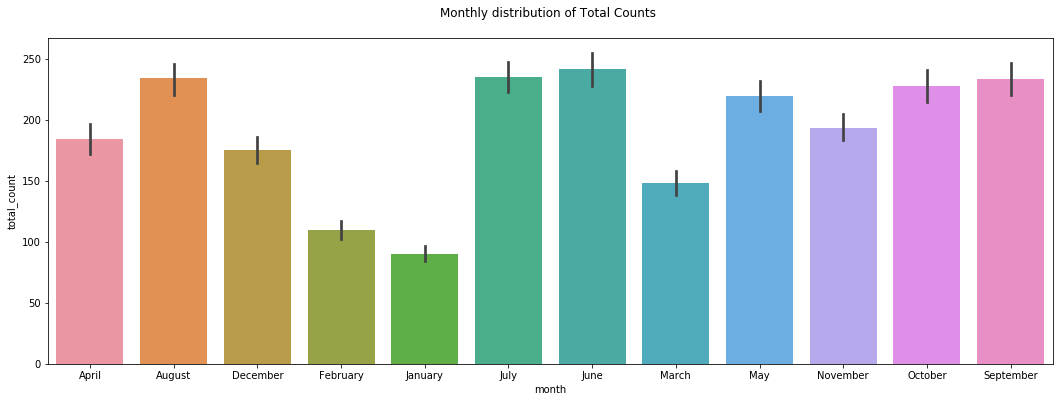

In [18]:
# Visualizing monthly ridership counts.

fig, ax = plt.subplots(figsize = (18,6))
sns.barplot(data = hourly_data[['month', 'total_count']], 
              x = 'month', y = 'total_count', ax = ax)
ax.set(title = "Monthly distribution of Total Counts \n")

**Observations**:

1. The months **June-September** shows the highest ridership. 
2. Looks like Fall is a good season for Bike Sharing programs in Washington, D.C.

[Text(0.5, 1.0, ' Monthwise Distribution of Total Counts in Every Season. \n')]

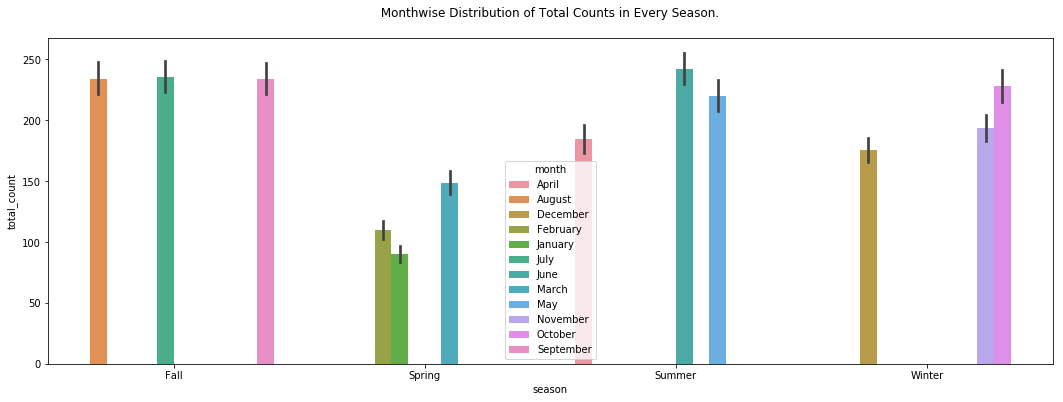

In [19]:
# Visualizing Seasonly Ridership counts ---- Fall, Spring, Summer, Winter

fig, ax = plt.subplots(figsize = (18,6))

sns.barplot(data = hourly_data[['season','total_count', 'month']], 
              x = 'season', y = 'total_count', hue = 'month', ax = ax)
ax.set(title = " Monthwise Distribution of Total Counts in Every Season. \n")

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([  1,   1,   1, ..., 968, 970, 977], dtype=int64)),
 (169.82942673231383, 191.5741319125482, 0.9372682766213174))

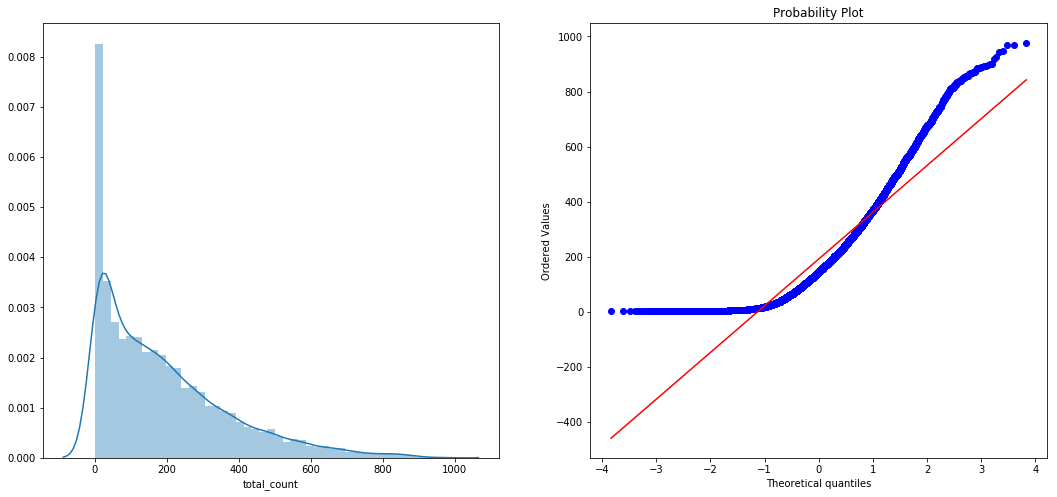

In [20]:
# Visualizing the distribution of Data

fig, (ax1,ax2) = plt.subplots(figsize = (18,8), nrows = 1, ncols = 2)

sns.distplot(hourly_data['total_count'], ax = ax1)
stats.probplot(hourly_data['total_count'], dist='norm', fit = True, plot = ax2)

**Observations**
1. Data is Right Skewed and seems to have lil bit normally distributed but it is necessary for modeling that the data should be Normally distributed.
2. Before moving to any conclusion we should perform Outliers Analysis

## Outliers Analysis

Text(0.5, 1.0, 'Box Plot On Temprature and Wind Speed\n')

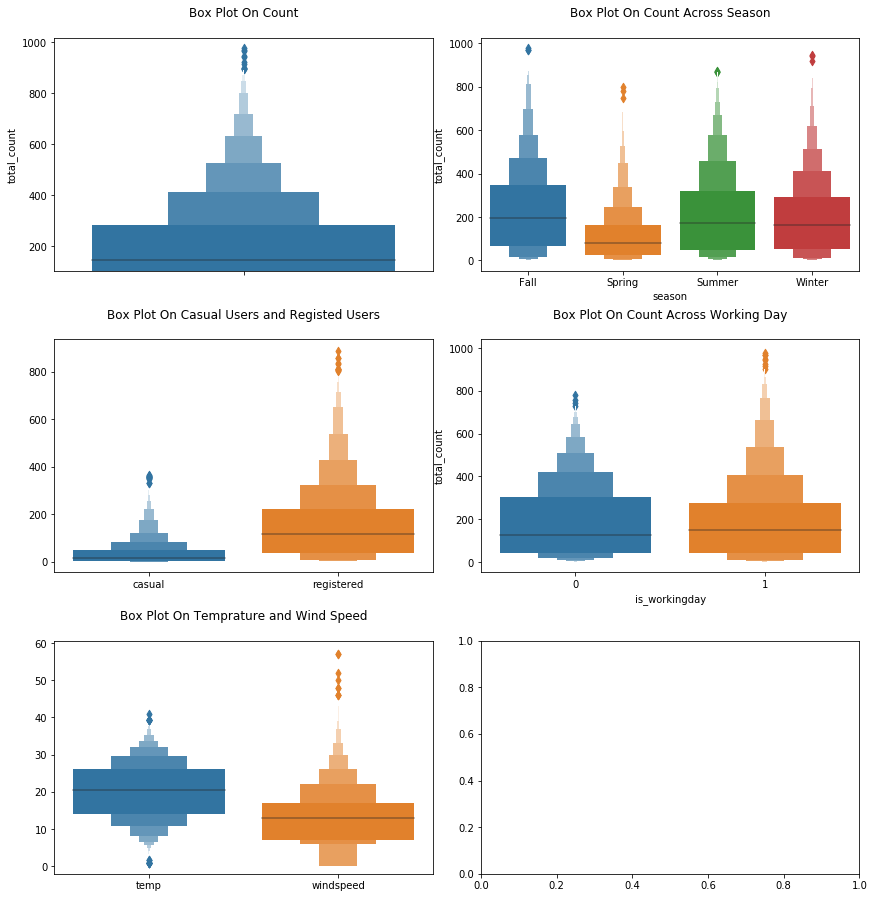

In [21]:
# Though we handle missing and incorrect information while preprocessing the dataset, 
#outliers are usually caught during EDA.

fig, ax = plt.subplots(figsize = (12,6), nrows = 3, ncols = 2)

# https://stackoverflow.com/questions/7066121/how-to-set-a-single-main-title-above-all-the-subplots-with-pyplot
fig.tight_layout()
fig.subplots_adjust(top=2)

# Box-plot for total_count
sns.boxenplot(data = hourly_data, y = 'total_count', orient = 'v',ax=ax[0][0])

# Box-plot for season vs total_count
sns.boxenplot(data = hourly_data, x = 'season' , y = 'total_count', orient = 'v', ax = ax[0][1])

# Box-plot for casual, registered
sns.boxenplot(data = hourly_data[['casual', 'registered']],ax = ax[1][0])

# Box-plot for is_workingday vs total_count
sns.boxenplot(data = hourly_data, x = 'is_workingday', y = 'total_count', orient = 'v', ax = ax[1][1])

# Box-plot for temp, windspeed
sns.boxenplot(data = hourly_data[['temp', 'windspeed']], ax = ax[2][0])


ax[0,0].set_title ("Box Plot On Count\n")

ax[0,1].set_title ("Box Plot On Count Across Season\n")

ax[1,0].set_title ("Box Plot On Casual Users and Registed Users\n")

ax[1,1].set_title ("Box Plot On Count Across Working Day\n")

ax[2,0].set_title ("Box Plot On Temprature and Wind Speed\n")

**Observations**
1. Count related attributes seems to have a sizable number of outlier values.
2. The median value in boxplot proves that Spring season has relatively lower count.
3. The casual user distribution has lower number of outliers than the registerd one.
4. Most of the outlier are mainly contributed from "is_workingday == 1".
5. For weather attributes of temperature and wind speed, we find outliers only in the case of wind speed. 

[Text(0, 0.5, 'total_count'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Box Plot On Count Across Hour Of The Day\n')]

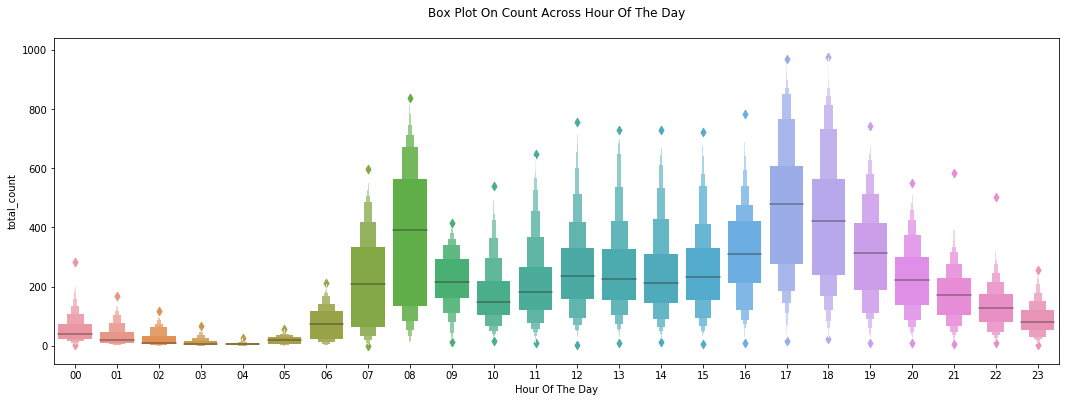

In [22]:
# Box-plot for Hour vs total_count

fig, ax = plt.subplots(figsize = (18,6))
sns.boxenplot(data = hourly_data, x = 'hour', y = 'total_count', orient = 'v', ax = ax)
ax.set(xlabel='Hour Of The Day', ylabel='total_count',title="Box Plot On Count Across Hour Of The Day\n")

**Observations**
1. The median values are relatively higher at 7AM - 8AM and 5PM - 6PM. It can be due to schooling and office hours.

In [23]:
### Outliers Removal

hourly_data_wo_out = hourly_data[np.abs(hourly_data["total_count"]-hourly_data["total_count"].mean())<=(3*hourly_data["total_count"].std())] 

In [24]:
print ("Shape Of The Before Ouliers: ", hourly_data.shape)
print ("Shape Of The After Ouliers: ", hourly_data_wo_out.shape)

Shape Of The Before Ouliers:  (10886, 17)
Shape Of The After Ouliers:  (10739, 17)


# 2.4 EDA After Outlier Removal

## Correlation Analysis

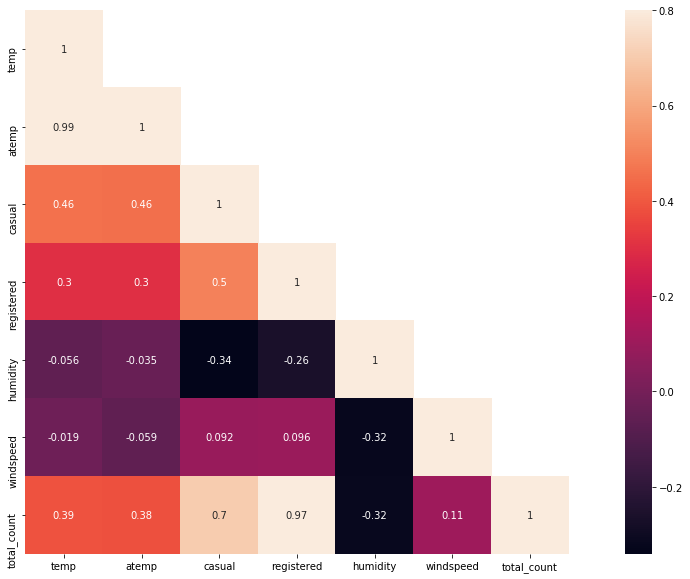

In [25]:
# Correlation helps us understand relationships between different attributes of the data.
# Can be obatianed between Numerical variables 
# i.e "total_count" and ["temp","atemp","humidity","windspeed", "casual", "registered"].

correlation_matrix = hourly_data_wo_out[["temp","atemp","casual","registered","humidity","windspeed","total_count"]].corr()
mask = np.array(correlation_matrix)
mask[np.tril_indices_from(mask)] = False
fig,ax = plt.subplots(figsize = (20,10))
sns.heatmap(correlation_matrix, mask = mask, vmax=.8, square = True, annot = True)

**Observations**
1. 'temp' feature has got positive and negative correlation with 'total_count'. Although the correlation between them is not very prominent still 'total_count' have little dependency on 'temp'.
2. 'humidity' features has got negative correlation with 'total_count'.
3. 'windspeed' is not a useful feature as it has no correlation with 'total_count'.
4. 'atemp' not taken into consideration as "atemp" and "temp" has got strong correlation with each other. So at the time of modeling there can be issue of multicollinearity. So one of the variable has to be dropped.
5. 'casual' and 'registered' should not be taken into consideration as they are leakage variables and hence should be dropped.
6. Overall, none of the attributes show high correlational statistics

## Regression Plots

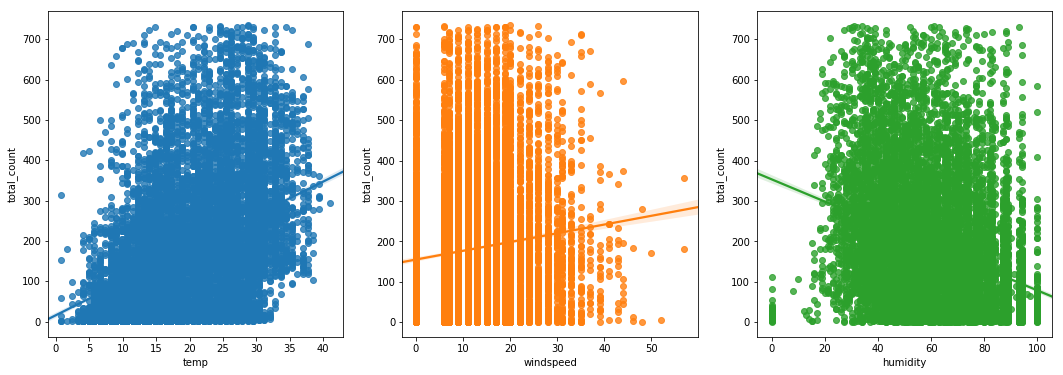

In [26]:
# This depicts the relationship between two features. 
# Here we consider "total_count" vs "temp", "humidity", "windspeed".
# It is the process of investigating relationships between dependent and independent variables.

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (18, 6), ncols = 3)
sns.regplot(x = "temp", y = "total_count", data = hourly_data_wo_out, ax = ax1)
sns.regplot(x = "windspeed", y = "total_count", data = hourly_data_wo_out, ax = ax2)
sns.regplot(x = "humidity", y = "total_count", data = hourly_data_wo_out, ax = ax3)

## Data Visualization : Distribution and Trends

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([  1,   1,   1, ..., 732, 733, 734], dtype=int64)),
 (157.6468423658611, 183.00381786013588, 0.9455240333561122))

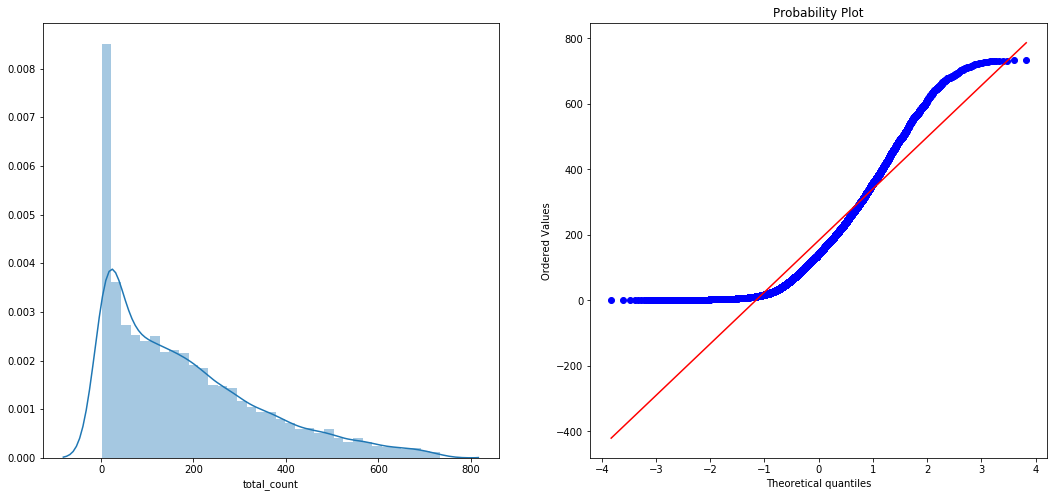

In [27]:
# Usually, most of the machine learning techniques require dependent variable to be Normally distributed. 
# So visualizing the data after removing outliers.
# Dependent Variable --- 'total_count'

fig, (ax1,ax2) = plt.subplots(figsize = (18,8), nrows = 1, ncols = 2)

sns.distplot(hourly_data_wo_out['total_count'], ax = ax1)
stats.probplot(hourly_data_wo_out['total_count'], dist='norm', fit = True, plot = ax2)

**Observations**
1. As it is visible from the below figures that "total_count" variable is skewed towards right.
2. One possible solution to this is to take log transformation on "total_count" variable so as it could be Normally Distributed (Not ideal but almost similar).

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.        , 0.        , 0.        , ..., 6.59578051, 6.5971457 ,
         6.59850903])),
 (1.4096846101542908, 4.523106928071492, 0.9537631807794263))

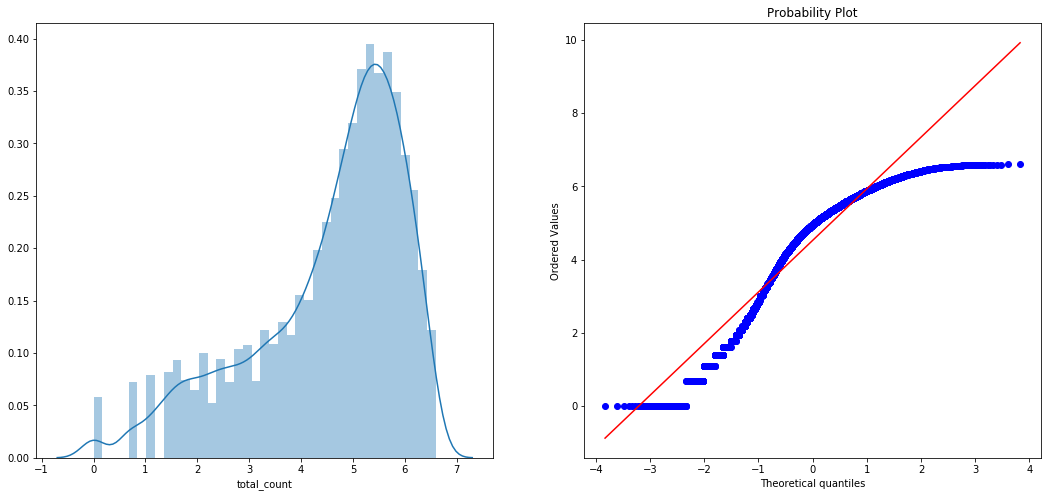

In [28]:
# Applying log transformation on 'total_count' variable of data without Outliers

fig, (ax1,ax2) = plt.subplots(figsize = (18,8), nrows = 1, ncols = 2)

sns.distplot(np.log(hourly_data_wo_out['total_count']), ax = ax1)
stats.probplot(np.log(hourly_data_wo_out['total_count']), dist='norm', fit = True, plot = ax2)

**Observations**
1. After the log transformation the data looks better but still it is not ideally following normal distribution.

[Text(0.5, 1.0, 'Monthly distribution of Total Counts \n')]

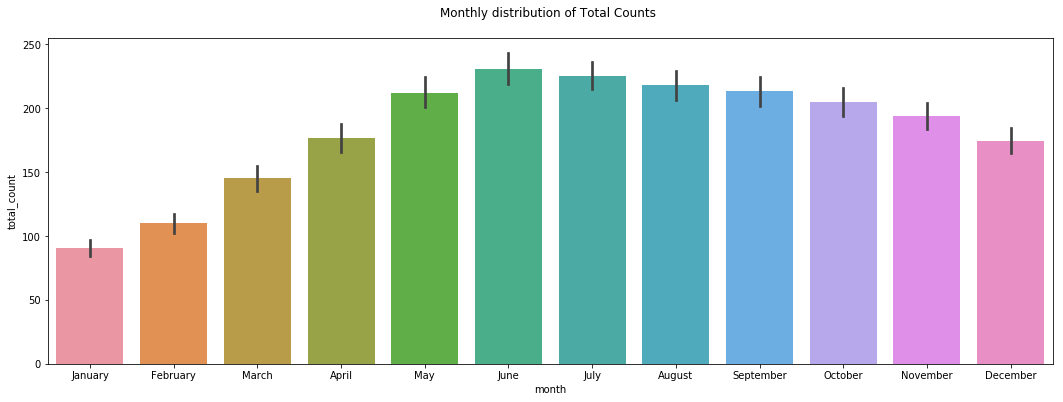

In [29]:
# Visualizing monthly ridership counts.

sortOrder = ["January","February","March","April","May","June","July","August","September","October",
             "November","December"]

fig, ax = plt.subplots(figsize = (18,6))
sns.barplot(data = hourly_data_wo_out[['month', 'total_count']], x = 'month', y = 'total_count', ax = ax, 
            order = sortOrder)
ax.set(title = "Monthly distribution of Total Counts \n")

[Text(0.5, 1.0, 'Season wise Hourly distribution of Total Counts \n')]

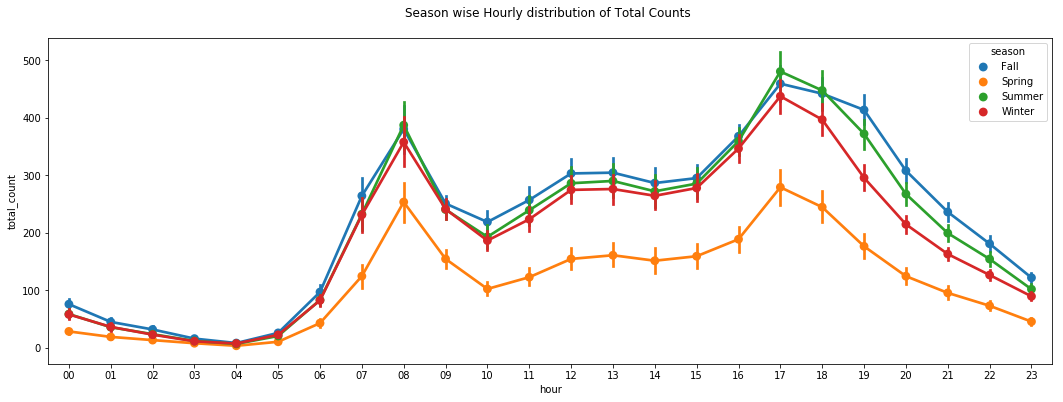

In [30]:
# Visualizing hourly ridership counts across the seasons.

fig, ax = plt.subplots(figsize = (18,6))
sns.pointplot(data = hourly_data_wo_out[['hour', 'season', 'total_count']],
              x = 'hour', y = 'total_count', hue = 'season', ax = ax)
ax.set(title = "Season wise Hourly distribution of Total Counts \n")

[Text(0.5, 1.0, 'Day wise Hourly Distribution of Total Counts \n')]

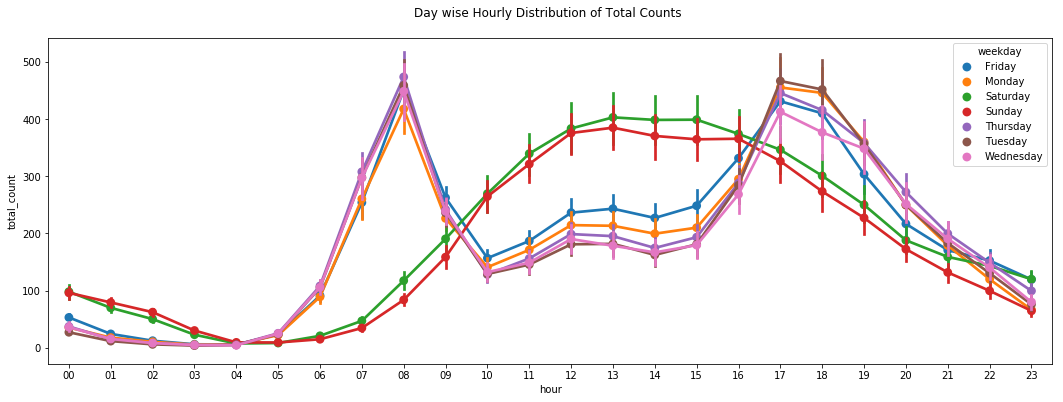

In [31]:
# Visualizing hourly ridership counts across the weekdays.

fig, ax = plt.subplots(figsize = (18,6))
sns.pointplot(data = hourly_data_wo_out[['hour', 'weekday', 'total_count']], 
              x = 'hour', y = 'total_count', hue = 'weekday', ax = ax)
ax.set(title = "Day wise Hourly Distribution of Total Counts \n")

[Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across User Type\n')]

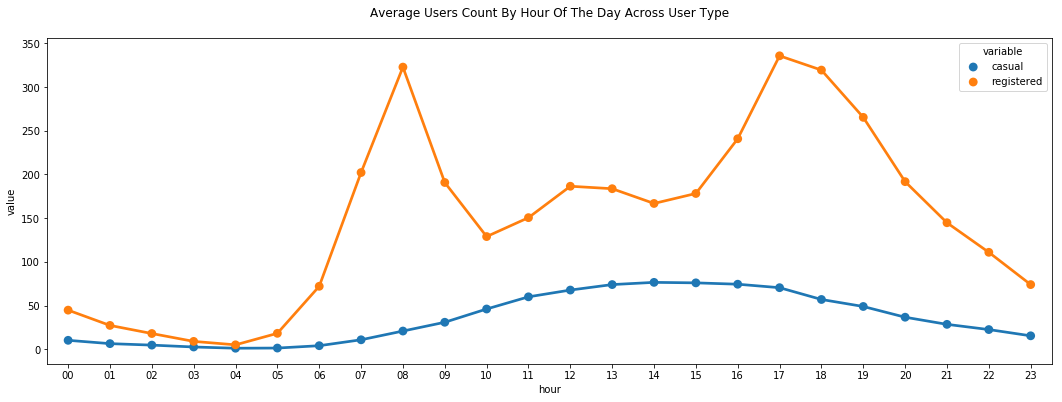

In [32]:
# Visualizing hourly casual and registered ridership counts.

fig, ax = plt.subplots(figsize = (18,6))
hourTransformed = pd.melt(hourly_data_wo_out[["hour","casual","registered"]], id_vars = ['hour'], 
                          value_vars = ['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort = True)
                              ["value"].mean()).reset_index()
sns.pointplot(x = hourAggregated["hour"], y = hourAggregated["value"], hue = hourAggregated["variable"],
             hue_order = ["casual","registered"], data = hourAggregated, join = True, ax = ax)
ax.set(title = "Average Users Count By Hour Of The Day Across User Type\n")

**Observations**
1. It is quiet obvious that people tend to rent bike during summer season since it is really conducive to ride bike at that season.Therefore June, July and August has got relatively higher demand for bicycle.
2. On weekdays more people tend to rent bicycle around 7AM-8AM and 5PM-6PM. As we mentioned earlier this can be attributed to regular school and office commuters.
3. Above pattern is not observed on "Saturday" and "Sunday".More people tend to rent bicycle between 10AM and 4PM.
4. The peak user count around 7AM-8AM and 5PM-6PM is purely contributed by registered user.

# 3. Test Data Analysis

# 3.1 Loading Test Data

In [33]:
test_data = pd.read_csv('test.csv')

In [34]:
test_data.head(20)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
5,2011-01-20 05:00:00,1,0,1,1,9.84,11.365,60,15.0013
6,2011-01-20 06:00:00,1,0,1,1,9.02,10.605,60,15.0013
7,2011-01-20 07:00:00,1,0,1,1,9.02,10.605,55,15.0013
8,2011-01-20 08:00:00,1,0,1,1,9.02,10.605,55,19.0012
9,2011-01-20 09:00:00,1,0,1,2,9.84,11.365,52,15.0013


# 3.2 Data Cleaning

In [35]:
# Clean up the attribute names to make them more understandable.

test_data.rename(columns = {'holiday':'is_holiday','workingday':'is_workingday'}, inplace = True)

## Feature Engineering

In [36]:
# Creating New Columns From "datetime" Column

test_data["date"] = test_data.datetime.apply(lambda x : x.split()[0])
test_data["hour"] = test_data.datetime.apply(lambda x : x.split()[1].split(":")[0])

test_data["season"] = test_data.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
test_data["weather"] = test_data.weather.map({1: "Clear, Few clouds, Partly cloudy",\
                                        2 : "Cloudy, Broken clouds, Few clouds, Mist", \
                                        3 : "Light Snow, Light Rain, Thunderstorm, Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :"Heavy Rain, Ice Pallets, Thunderstorm, Mist, Snow, Fog" })

test_data["weekday"] = test_data.date.apply(lambda x : calendar.day_name[datetime.strptime(x,"%Y-%m-%d").weekday()])
test_data["month"] = test_data.date.apply(lambda x : calendar.month_name[datetime.strptime(x,"%Y-%m-%d").month])
test_data["year"] = test_data.datetime.apply(lambda x : x.split()[0].split('-')[0])

In [37]:
# check what data types pandas has inferred and if any of the attributes require type conversions

test_data.dtypes

datetime          object
season            object
is_holiday         int64
is_workingday      int64
weather           object
temp             float64
atemp            float64
humidity           int64
windspeed        float64
date              object
hour              object
weekday           object
month             object
year              object
dtype: object

In [38]:
# Attributes like "hour", "weekday" ,"month" ,"season" ,"weather"  are inferred as objects but require the conversion to categoricals.
# Also Attributes like "is_holiday", "is_workingday" are inferred as integers but require the conversion to categoricals.

# categorical variables
category_var_list = ["hour", "weekday" ,"month" ,"season" ,"weather","is_holiday", "is_workingday", "year"]

for var in category_var_list:
    
    test_data[var] = test_data[var].astype('category')

In [39]:
test_data.dtypes

datetime           object
season           category
is_holiday       category
is_workingday    category
weather          category
temp              float64
atemp             float64
humidity            int64
windspeed         float64
date               object
hour             category
weekday          category
month            category
year             category
dtype: object

In [40]:
# Missing Values Analysis

print('Number of missing values :\n{}'.format(test_data.isnull().sum()))

Number of missing values :
datetime         0
season           0
is_holiday       0
is_workingday    0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
date             0
hour             0
weekday          0
month            0
year             0
dtype: int64


In [41]:
print(test_data[test_data['windspeed'] == 0.0000])

                 datetime  season is_holiday is_workingday  \
1     2011-01-20 01:00:00  Spring          0             1   
2     2011-01-20 02:00:00  Spring          0             1   
12    2011-01-20 12:00:00  Spring          0             1   
60    2011-01-22 13:00:00  Spring          0             0   
62    2011-01-22 15:00:00  Spring          0             0   
64    2011-01-22 17:00:00  Spring          0             0   
69    2011-01-22 22:00:00  Spring          0             0   
100   2011-01-24 07:00:00  Spring          0             1   
101   2011-01-24 08:00:00  Spring          0             1   
102   2011-01-24 09:00:00  Spring          0             1   
103   2011-01-24 10:00:00  Spring          0             1   
130   2011-01-25 14:00:00  Spring          0             1   
131   2011-01-25 15:00:00  Spring          0             1   
132   2011-01-25 16:00:00  Spring          0             1   
133   2011-01-25 17:00:00  Spring          0             1   
177   20

**Observations**
1. As it can be observed that there are lots of datapoints having windspeed = 0. So we need to fill those windspeed values

# 3.3 Prediction of Windspeed Values 

### Combining Train And Test

In [42]:
data = hourly_data_wo_out.append(test_data)
data.reset_index(inplace = True)
data.drop('index',inplace = True,axis = 1)

In [43]:
data.head()

,atemp,casual,date,datetime,hour,humidity,is_holiday,is_workingday,month,registered,season,temp,total_count,weather,weekday,windspeed,year
0,14.395,3.0,2011-01-01,2011-01-01 00:00:00,00,81,0,0,January,13.0,Spring,9.84,16.0,"Clear, Few clouds, Partly cloudy",Saturday,0.0,2011
1,13.635,8.0,2011-01-01,2011-01-01 01:00:00,01,80,0,0,January,32.0,Spring,9.02,40.0,"Clear, Few clouds, Partly cloudy",Saturday,0.0,2011
2,13.635,5.0,2011-01-01,2011-01-01 02:00:00,02,80,0,0,January,27.0,Spring,9.02,32.0,"Clear, Few clouds, Partly cloudy",Saturday,0.0,2011
3,14.395,3.0,2011-01-01,2011-01-01 03:00:00,03,75,0,0,January,10.0,Spring,9.84,13.0,"Clear, Few clouds, Partly cloudy",Saturday,0.0,2011
4,14.395,0.0,2011-01-01,2011-01-01 04:00:00,04,75,0,0,January,1.0,Spring,9.84,1.0,"Clear, Few clouds, Partly cloudy",Saturday,0.0,2011


In [44]:
data.shape

(17232, 17)

In [45]:
# As we could not convert string to float so remapping the 'season' and 'month' feature

data["season"] = data.season.map({"Spring":1, "Summer":2, "Fall":3, "Winter":4 })
data["month"] = data.month.map({"January":1, "February":2, "March":3, "April":4, 
                                "May":5, "June":6, "July":7, "August":8,
                                "September":9, "October":10, "November":11, "December":12 })
data["weather"] = data.weather.map({"Clear, Few clouds, Partly cloudy":1,\
                                    "Cloudy, Broken clouds, Few clouds, Mist":2,\
                                    "Light Snow, Light Rain, Thunderstorm, Scattered clouds, Light Rain + Scattered clouds":3, \
                                    "Heavy Rain, Ice Pallets, Thunderstorm, Mist, Snow, Fog":4 })
data["weekday"] = data.weekday.map({"Sunday":1, "Monday":2, "Tuesday":3, "Wednesday":4, 
                                    "Thursday":5, "Friday":6, "Saturday":7})

In [46]:
data.head()

,atemp,casual,date,datetime,hour,humidity,is_holiday,is_workingday,month,registered,season,temp,total_count,weather,weekday,windspeed,year
0,14.395,3.0,2011-01-01,2011-01-01 00:00:00,00,81,0,0,1,13.0,1,9.84,16.0,1,7,0.0,2011
1,13.635,8.0,2011-01-01,2011-01-01 01:00:00,01,80,0,0,1,32.0,1,9.02,40.0,1,7,0.0,2011
2,13.635,5.0,2011-01-01,2011-01-01 02:00:00,02,80,0,0,1,27.0,1,9.02,32.0,1,7,0.0,2011
3,14.395,3.0,2011-01-01,2011-01-01 03:00:00,03,75,0,0,1,10.0,1,9.84,13.0,1,7,0.0,2011
4,14.395,0.0,2011-01-01,2011-01-01 04:00:00,04,75,0,0,1,1.0,1,9.84,1.0,1,7,0.0,2011


In [47]:
# Missing Values Analysis

print('Number of missing values :\n{}'.format(data.isnull().sum()))

Number of missing values :
atemp               0
casual           6493
date                0
datetime            0
hour                0
humidity            0
is_holiday          0
is_workingday       0
month               0
registered       6493
season              0
temp                0
total_count      6493
weather             0
weekday             0
windspeed           0
year                0
dtype: int64


### Applying Random Forest Model To Predict 0's In Windspeed

In [48]:
# Collecting Data
wind_eq_0 = data[data['windspeed'] == 0]
wind_not_eq_0 = data[data['windspeed'] != 0]

# All environmental related features are required for predicting 'windspeed'
wind_related_col = ["season" ,"weather" ,"humidity" ,"temp" ,"year" ,"atemp", "month"]

In [49]:
# Modeling
from sklearn.ensemble import RandomForestRegressor

RF = RandomForestRegressor()
RF.fit(wind_not_eq_0[wind_related_col], wind_not_eq_0['windspeed'])
pred_wind_val = RF.predict(wind_eq_0[wind_related_col])

In [50]:
# Mergeing the data
wind_eq_0['windspeed'] = pred_wind_val
data = wind_not_eq_0.append(wind_eq_0)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

# 4. Final Modeling

In [51]:
data.head()

,atemp,casual,date,datetime,hour,humidity,is_holiday,is_workingday,month,registered,season,temp,total_count,weather,weekday,windspeed,year
0,12.880,0.0,2011-01-01,2011-01-01 05:00:00,05,75,0,0,1,1.0,1,9.84,1.0,2,7,6.0032,2011
1,19.695,12.0,2011-01-01,2011-01-01 10:00:00,10,76,0,0,1,24.0,1,15.58,36.0,1,7,16.9979,2011
2,16.665,26.0,2011-01-01,2011-01-01 11:00:00,11,81,0,0,1,30.0,1,14.76,56.0,1,7,19.0012,2011
3,21.210,29.0,2011-01-01,2011-01-01 12:00:00,12,77,0,0,1,55.0,1,17.22,84.0,1,7,19.0012,2011
4,22.725,47.0,2011-01-01,2011-01-01 13:00:00,13,72,0,0,1,47.0,1,18.86,94.0,2,7,19.9995,2011


# 4.1 Train-Test Splitting

In [52]:
# training data
train_data = data[pd.notnull(data['total_count'])].sort_values(by = ["datetime"])
tr_labels_count = train_data["total_count"]
tr_labels_registered = train_data["registered"]
tr_labels_casual = train_data["casual"]

# testing data
test_data = data[~pd.notnull(data['total_count'])].sort_values(by = ["datetime"])
date_time_col = test_data["datetime"]

In [53]:
# Dropping Unwanted Features

drop_features = ["casual", "datetime", "date", "registered", "total_count"]
train_data = train_data.drop(drop_features, axis =1)
test_data = test_data.drop(drop_features, axis = 1)

In [54]:
train_data.head()

,atemp,hour,humidity,is_holiday,is_workingday,month,season,temp,weather,weekday,windspeed,year
15068,14.395,00,81,0,0,1,1,9.84,1,7,7.727277,2011
15069,13.635,01,80,0,0,1,1,9.02,1,7,7.002170,2011
15070,13.635,02,80,0,0,1,1,9.02,1,7,7.002170,2011
15071,14.395,03,75,0,0,1,1,9.84,1,7,6.427478,2011
15072,14.395,04,75,0,0,1,1,9.84,1,7,6.427478,2011


In [55]:
test_data.head()

,atemp,hour,humidity,is_holiday,is_workingday,month,season,temp,weather,weekday,windspeed,year
9442,11.365,00,56,0,1,1,1,10.66,1,5,26.0027,2011
16365,13.635,01,56,0,1,1,1,10.66,1,5,8.9981,2011
16366,13.635,02,56,0,1,1,1,10.66,1,5,8.9981,2011
9443,12.880,03,56,0,1,1,1,10.66,1,5,11.0014,2011
9444,12.880,04,56,0,1,1,1,10.66,1,5,11.0014,2011


# 4.2 Evaluation Metric 

In [56]:
# Root Mean Squared Logarithmic Error (RMSLE)

def rmsle(y_act, y_pred, convertExp = True):
    if convertExp:
        y_act = np.exp(y_act),
        y_pred = np.exp(y_pred)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y_act]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_pred]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [57]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 4.3 Linear Regression Model

In [58]:
# Linear Regression
LR = LinearRegression()

train_labels_log = np.log1p(tr_labels_count)

# Train the model
LR.fit(train_data, train_labels_log)

# Making Predictions
pred = LR.predict(train_data)

# Performance
print ("RMSLE Value For Linear Regression: ", rmsle(np.exp(train_labels_log), np.exp(pred), False))

RMSLE Value For Linear Regression:  0.9766413780042555


# 4.4 Regularization Model - Ridge Regression

Best Parameters :  {'alpha': 0.0001, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9766413779794989


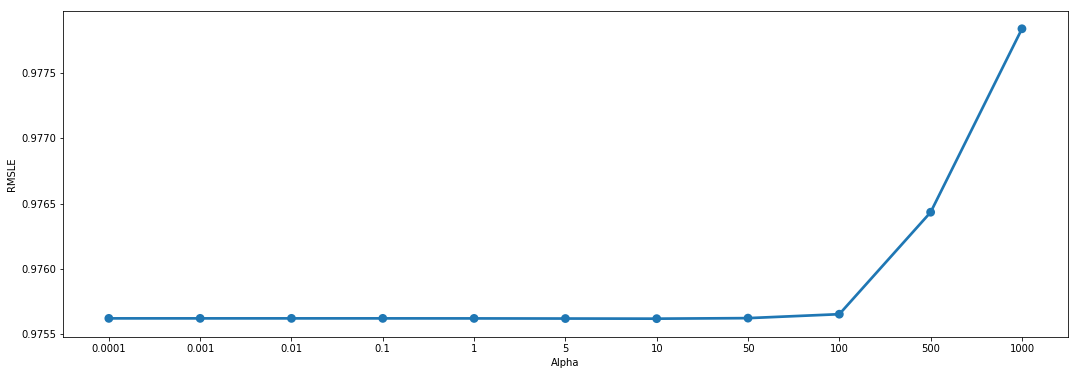

In [59]:
# Ridge Regression
RDG = Ridge()
ridge_param = {'max_iter':[3000],'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 500, 1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better = False)
grid_ridge_model = GridSearchCV(RDG, ridge_param, scoring = rmsle_scorer, cv = 5)
yLabelsLog = np.log1p(tr_labels_count)
grid_ridge_model.fit(train_data, train_labels_log)
pred = grid_ridge_model.predict(train_data)
print ("Best Parameters : ",grid_ridge_model.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(train_labels_log), np.exp(pred), False))

fig,ax = plt.subplots(figsize = (18,6))
dataframe = pd.DataFrame(grid_ridge_model.cv_results_)
dataframe["Alpha"] = dataframe["param_alpha"]
dataframe["RMSLE"] = dataframe["mean_train_score"].apply(lambda x: -x)
sns.pointplot(data = dataframe, x = "Alpha", y = "RMSLE", ax = ax)

# 4.5 Regularization Model - Lasso Regression

Best Parameters :  {'alpha': 0.001, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9766599037190271


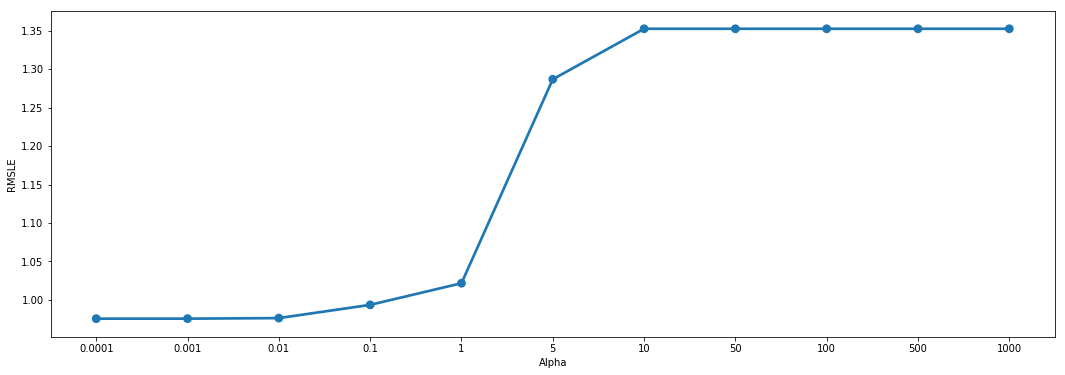

In [60]:
# Lasso Regression
Lasso = Lasso()
lasso_param = {'max_iter':[3000],'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 500, 1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better = False)
grid_lasso_model = GridSearchCV(Lasso, lasso_param, scoring = rmsle_scorer, cv = 5)
yLabelsLog = np.log1p(tr_labels_count)
grid_lasso_model.fit(train_data, train_labels_log)
pred = grid_lasso_model.predict(train_data)
print ("Best Parameters : ",grid_lasso_model.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(train_labels_log), np.exp(pred), False))

fig,ax = plt.subplots(figsize = (18,6))
dataframe = pd.DataFrame(grid_lasso_model.cv_results_)
dataframe["Alpha"] = dataframe["param_alpha"]
dataframe["RMSLE"] = dataframe["mean_train_score"].apply(lambda x: -x)
sns.pointplot(data = dataframe, x = "Alpha", y = "RMSLE", ax = ax)

 # 4.6 Polymonial Regression

In [61]:
# https://austinrochford.com/posts/2013-12-12-polynomial-regression-cross-validation.html

# 4.7 Ensemble Models - Random Forest

In [62]:
# https://austinrochford.com/posts/2013-12-12-polynomial-regression-cross-validation.html

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [63]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 15, num = 1)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [1, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 5],
 'n_estimators': [10,
                  25,
                  40,
                  55,
                  71,
                  86,
                  101,
                  116,
                  132,
                  147,
                  162,
                  177,
                  193,
                  208,
                  223,
                  238,
                  254,
                  269,
                  284,
                  300]}


In [64]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(train_data, train_labels_log)
pred = rf_random.predict(train_data)
print ("Best Parameters : ",rf_random.best_params_)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(train_labels_log),np.exp(pred),False))

# To see the Exact Hyper Parameter Tuning results 
dataframe = pd.DataFrame(rf_random.cv_results_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.3min finished


Best Parameters :  {'n_estimators': 223, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
RMSLE Value For Random Forest:  0.10239728729551348


# 4.8 Ensemble Model - Gradient Boosting 

In [65]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(random_state = 42)
from pprint import pprint

# Look at parameters used by our current Boosting
print('Parameters currently in use:\n')
pprint(gb.get_params())

Parameters currently in use:

{'alpha': 0.9,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [66]:
from sklearn.model_selection import RandomizedSearchCV

# Alpha values
alpha = [0.0001, 0.001, 0.01, 0.1, 0.5, 0.9]
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 15, num = 1)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'alpha' : alpha}

pprint(random_grid)

{'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 0.9],
 'max_depth': [1, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 5],
 'n_estimators': [10,
                  25,
                  40,
                  55,
                  71,
                  86,
                  101,
                  116,
                  132,
                  147,
                  162,
                  177,
                  193,
                  208,
                  223,
                  238,
                  254,
                  269,
                  284,
                  300]}


In [67]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
gb = GradientBoostingRegressor()

# Random search of parameters, using 3 fold cross validation, 
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
gb_random.fit(train_data, train_labels_log)
pred = gb_random.predict(train_data)
print ("Best Parameters : ",gb_random.best_params_)
print ("RMSLE Value For Gradient Boosting: ",rmsle(np.exp(train_labels_log),np.exp(pred),False))

# To see the Exact Hyper Parameter Tuning results 
dataframe = pd.DataFrame(gb_random.cv_results_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 15.7min finished


Best Parameters :  {'n_estimators': 269, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'alpha': 0.0001}
RMSLE Value For Gradient Boosting:  0.006978228312913021


# 4.9 Model Conclusions

In [71]:
print ("Root Mean Squared Logarithmic Error   -  RMSLE ")
print ("---------------------------------------------------------------------------------------------------------------")
print ("Linear Regression Model                 -       RMSLE Value For Linear Regression Train :: 0.9766364194924931")
print ("Regularization Model - Ridge Regression -       RMSLE Value For Linear Regression Train :: 0.9766364194677553")
print ("Regularization Model - Lasso Regression -       RMSLE Value For Linear Regression Train :: 0.9766545499390118")
print ("Ensemble Models - Random Forest         -       RMSLE Value For Linear Regression Train :: 0.1023882225418457")
print ("Ensemble Model - Gradient Boosting      -       RMSLE Value For Linear Regression Train :: 0.006978228312913021")
print ("---------------------------------------------------------------------------------------------------------------")

Root Mean Squared Logarithmic Error   -  RMSLE 
---------------------------------------------------------------------------------------------------------------
Linear Regression Model                 -       RMSLE Value For Linear Regression Train :: 0.9766364194924931
Regularization Model - Ridge Regression -       RMSLE Value For Linear Regression Train :: 0.9766364194677553
Regularization Model - Lasso Regression -       RMSLE Value For Linear Regression Train :: 0.9766545499390118
Ensemble Models - Random Forest         -       RMSLE Value For Linear Regression Train :: 0.1023882225418457
Ensemble Model - Gradient Boosting      -       RMSLE Value For Linear Regression Train :: 0.006978228312913021
---------------------------------------------------------------------------------------------------------------


1. As the Train RMSLE is **Lowest** for **Ensemble Model - Gradient Boosting**, we will select it for **Predicting** the Values for **Test Data.**

# 5. Prediction

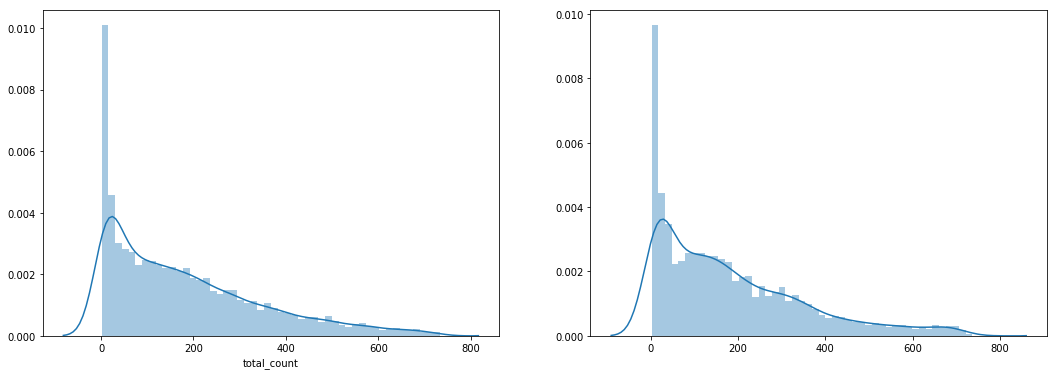

In [69]:
# Predicting values for Test Data

pred_test_data = gb_random.predict(test_data)
fig,(ax1,ax2)= plt.subplots(figsize = (18,6), ncols = 2)
sns.distplot(tr_labels_count, ax = ax1, bins = 50)
sns.distplot(np.exp(pred_test_data), ax = ax2, bins = 50)

# 6. Conclusions

1. LetsAfter comparing the **Distributions of train and test results** it has been observed that both the distributions **looks identical.** 
2. It confirms visually that our model **does not make really bad predictions** also **does not** suffers from the problem of **overfitting.**

# 7. Final Submission

In [70]:
final_submission = pd.DataFrame({"datetime": date_time_col , "total_count": [max(0, x) for x in np.exp(pred_test_data)]})
final_submission.to_csv('Bike_Predictions_Using_GB_Predictions.csv', index = False)

# 8. References and Links

1. https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile
2. Practical Machine Learning with Python: A Problem-Solver's Guide to Building Real-World Intelligent Systems --- Book by Dipanjan Sarkar, Raghav Bali, and Tushar Sharma
3. https://austinrochford.com/posts/2013-12-12-polynomial-regression-cross-validation.html
4. https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74